In [ ]:
# Import the necessary libraries
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from simpletransformers.classification import ClassificationModel

# Load and clean training data
df_train = pd.read_csv("big_data.csv")
df_train["review"] = df_train["review"].astype(str).str.strip() #  non-strings and strip whitespaces
df_train = df_train[df_train["review"] != ""] # also remove the rows where the review column is empty to ensure non-empty reviews

# Load test data
df_test = pd.read_csv("sentiment-topic-test.tsv", sep="\t") # Use \t as seperator to read .tsv-files

# We use a smaller subset with randomness due to the huge training time
df_train = df_train.sample(frac=0.05, random_state=42)  # use 5% of data

# Encode string labels into integers
label_encoder = LabelEncoder() # Initialize the label encoder
df_train["label"] = label_encoder.fit_transform(df_train["label"])

# Prepare training data by selecting 'review' and 'label' columns only
train_data = df_train[["review", "label"]]

# Initialize the BERT classification model
model = ClassificationModel(
    'bert', 'bert-base-cased', # the BERT initialization extracted from lab6
    num_labels=len(label_encoder.classes_), # Set the number of labels to the number of classes in our set
    args={
        # We have adjusted some arguments to (try) and decrease training time
        "reprocess_input_data": True,
        "overwrite_output_dir": True,
        "num_train_epochs": 1,
        "train_batch_size": 8
    },
    use_cuda=False # If the device has a GPU, this setting can be set to True, resulting in faster training. As our devices have
    # integrated graphics in our CPU, we have set this to False by default.
)

# Train the model
model.train_model(train_data)

# Predict on test data
predictions, _ = model.predict(df_test["sentence"].tolist())

# Convert predictions back to original labels
df_test["predicted_topic"] = label_encoder.inverse_transform(predictions)

# Show a few results
print(df_test[["sentence", "topic", "predicted_topic"]].head())

# Evaluate performance
print("\nClassification Report:")
print(classification_report(df_test["topic"], df_test["predicted_topic"], digits=3))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/anaconda3/envs/TextMining/lib/python3.11/site-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/12 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/752 [00:00<?, ?it/s]

0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/1 [00:00<?, ?it/s]

                                            sentence   topic predicted_topic
0  The stadium was alive with the roar of the cro...  sports          sports
1  That last-minute goal had me jumping out of my...  sports          sports
2  I couldn’t put the book down; it swept me into...    book            book
3  The story had its moments, though some parts f...    book            book
4  I enjoyed the way the timelines shifted, even ...    book            book

Classification Report:
              precision    recall  f1-score   support

        book      0.750     1.000     0.857         6
       movie      1.000     0.667     0.800         6
      sports      0.833     0.833     0.833         6

    accuracy                          0.833        18
   macro avg      0.861     0.833     0.830        18
weighted avg      0.861     0.833     0.830        18



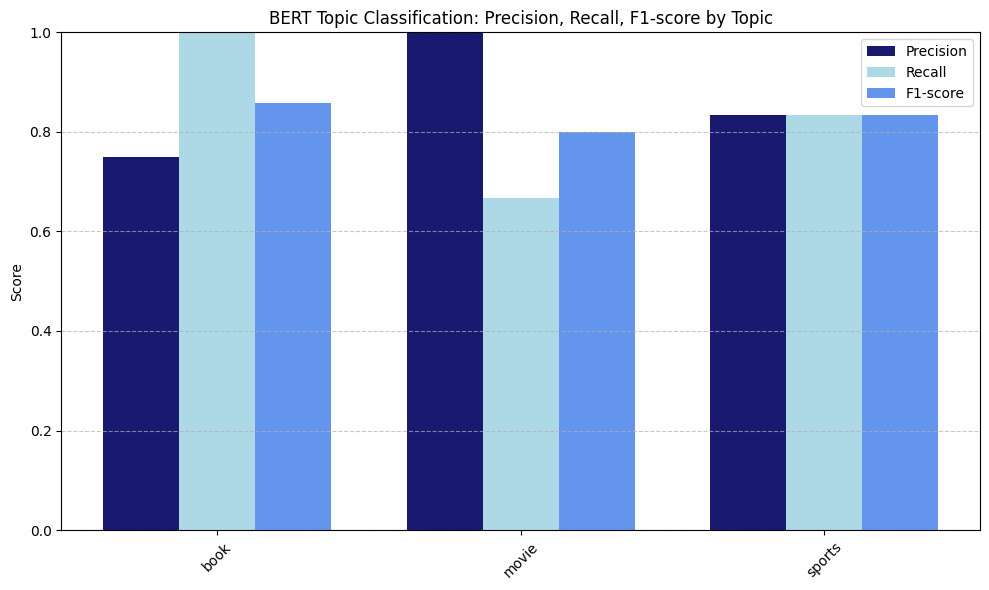

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report

# Generate classification report as dictionary
report_dict = classification_report(df_test["topic"], df_test["predicted_topic"], output_dict=True)

# Remove accuracy and macro/micro avg if present
labels = [label for label in report_dict if label in label_encoder.classes_]

# Get metrics
precision = [report_dict[label]["precision"] for label in labels]
recall = [report_dict[label]["recall"] for label in labels]
f1 = [report_dict[label]["f1-score"] for label in labels]

# Set up plot
x = np.arange(len(labels))  # label locations
width = 0.25  # width of bars

# Create bars
plt.figure(figsize=(10, 6))
plt.bar(x - width, precision, width, label='Precision', color='midnightblue')
plt.bar(x, recall, width, label='Recall', color='lightblue')
plt.bar(x + width, f1, width, label='F1-score', color='cornflowerblue')

# Formatting
plt.ylabel("Score")
plt.title("BERT Topic Classification: Precision, Recall, F1-score by Topic")
plt.xticks(ticks=x, labels=labels, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()